In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
df = pd.read_csv("PollenDataset/pollen_data.csv")

In [29]:
df.head()

,Unnamed: 0,filename,pollen_carrying
0,0,P10057-125r.jpg,1
1,1,P57380-120r.jpg,1
2,2,NP63671-221r.jpg,0
3,3,NP53776-47r.jpg,0
4,4,NP13382-201r.jpg,0


In [30]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [31]:
df.isnull().sum()

filename           0
pollen_carrying    0
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [33]:
def image_path(image):
    return f"PollenDataset/images/{image}"

In [34]:
df["filename"] = df["filename"].apply(image_path)

In [35]:
df["pollen_carrying"] = df["pollen_carrying"].map({
    0: "NO POLLEN", 1: "POLLEN"
})

In [36]:
df.head()

,filename,pollen_carrying
0,PollenDataset/images/P10057-125r.jpg,POLLEN
1,PollenDataset/images/P57380-120r.jpg,POLLEN
2,PollenDataset/images/NP63671-221r.jpg,NO POLLEN
3,PollenDataset/images/NP53776-47r.jpg,NO POLLEN
4,PollenDataset/images/NP13382-201r.jpg,NO POLLEN


In [37]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=4242)

In [38]:
data = []
label = []

images = df["filename"].values.tolist()

In [39]:
for i, file in enumerate(images):
    img = cv2.imread(file)
    img = cv2.resize(img, (224, 224))
    
    data.append(img)

In [40]:
label = df["pollen_carrying"].values.tolist()

In [41]:
len(data)

714

In [42]:
len(label)

714

In [43]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="pollen_carrying",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    subset="training"
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="pollen_carrying",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
    subset="validation"
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="pollen_carrying",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32,
)

Found 350 validated image filenames belonging to 2 classes.
Found 149 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


In [45]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [46]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
callbacks = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [52]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=100,
)

Epoch 1/100


2023-06-01 18:45:07.989323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 1.5124 - accuracy: 0.5535

2023-06-01 18:45:15.339755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 10s 716ms/step - loss: 1.5124 - accuracy: 0.5535 - val_loss: 0.9848 - val_accuracy: 0.7188
Epoch 2/100
10/10 [==============================] - 6s 639ms/step - loss: 0.3672 - accuracy: 0.8428 - val_loss: 0.3425 - val_accuracy: 0.8281
Epoch 3/100
10/10 [==============================] - 6s 652ms/step - loss: 0.2158 - accuracy: 0.9088 - val_loss: 0.4849 - val_accuracy: 0.7969
Epoch 4/100
10/10 [==============================] - 7s 715ms/step - loss: 0.1521 - accuracy: 0.9403 - val_loss: 0.4500 - val_accuracy: 0.8359
Epoch 5/100
10/10 [==============================] - 6s 650ms/step - loss: 0.1305 - accuracy: 0.9560 - val_loss: 0.3911 - val_accuracy: 0.8594
Epoch 6/100
10/10 [==============================] - 6s 643ms/step - loss: 0.0799 - accuracy: 0.9780 - val_loss: 0.3796 - val_accuracy: 0.8672
Epoch 7/100
10/10 [==============================] - 6s 658ms/step - loss: 0.0608 - accuracy: 0.9937 - val_loss: 0.4229 - val_accuracy: 0.8594
Epoch 8/10

10/10 [==============================] - 6s 588ms/step - loss: 3.5738e-04 - accuracy: 1.0000 - val_loss: 0.5572 - val_accuracy: 0.8750
Epoch 58/100
10/10 [==============================] - 6s 587ms/step - loss: 3.3559e-04 - accuracy: 1.0000 - val_loss: 0.6403 - val_accuracy: 0.8828
Epoch 59/100
10/10 [==============================] - 6s 589ms/step - loss: 3.2397e-04 - accuracy: 1.0000 - val_loss: 0.6130 - val_accuracy: 0.8750
Epoch 60/100
10/10 [==============================] - 6s 601ms/step - loss: 3.0079e-04 - accuracy: 1.0000 - val_loss: 0.5938 - val_accuracy: 0.8828
Epoch 61/100
10/10 [==============================] - 6s 590ms/step - loss: 3.0500e-04 - accuracy: 1.0000 - val_loss: 0.5644 - val_accuracy: 0.8750
Epoch 62/100
10/10 [==============================] - 6s 598ms/step - loss: 2.6998e-04 - accuracy: 1.0000 - val_loss: 0.6410 - val_accuracy: 0.8828
Epoch 63/100
10/10 [==============================] - 6s 599ms/step - loss: 2.4576e-04 - accuracy: 1.0000 - val_loss: 0.5963 

In [53]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.512404,0.553459,0.984845,0.718750
1,0.367206,0.842767,0.342473,0.828125
2,0.215768,0.908805,0.484924,0.796875
3,0.152109,0.940252,0.449987,0.835938
4,0.130455,0.955975,0.391128,0.859375


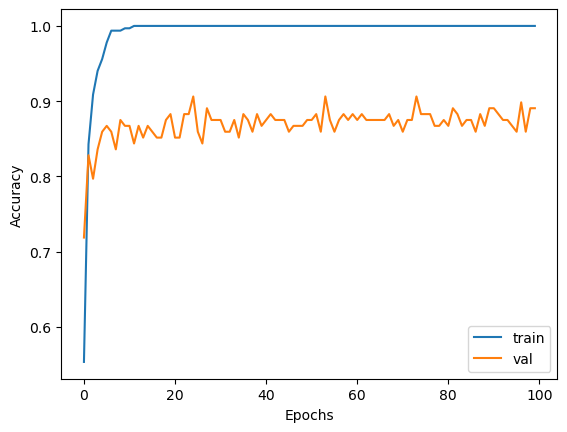

In [54]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

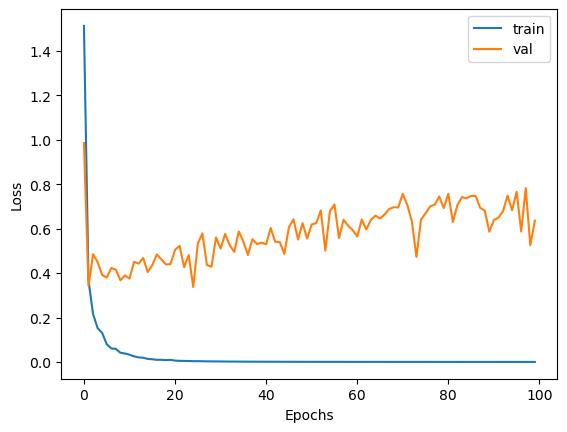

In [55]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

In [56]:
model.save("bee.h5")

In [58]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

2023-06-01 18:56:44.870251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 3s 382ms/step - loss: 0.4141 - accuracy: 0.8884
Test accuracy: 0.8883720636367798
